# Libraries
Importing all required library to create a CNN

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

ImportError: DLL load failed while importing _pywrap_tfe: The specified procedure could not be found.

### Access Google Drive

# Data

## Plot Random Image


In [1]:
# Plotting images to check dataset
plt.figure(figsize = (12, 12))
path = 'C:\Users\user\Documents\Datasets\Plant_images_pianalytix\Potato___Early_blight'
for i in range(1, 17):
  plt.subplot(4, 4, i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10) #-> Width of image
  plt.ylabel(rand_img.shape[0], fontsize = 10) #-> Height of image


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1393978822.py, line 3)

## Convert Image to Array
We need to convert the images into a numpy array because we will normalize our dataset after this.


In [9]:
def convert_image_to_array(image_dir):
  try:
    image = cv2.imread(image_dir)
    if image is not None:
      image = cv2.resize(image, (256, 256))
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f"Error : {e}")
    return None

In [17]:
dir = '/content/drive/MyDrive/Dataset/Plant_images_pianalytix'
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0, 1, 2]
temp = -1

#Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

In [18]:
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

,count
0,
0,300
1,300
2,300


In [23]:
#Shape of Image
image_list[0].shape

(256, 256, 3)

In [24]:
#Total Number of Images
label_list = np.array(label_list)
label_list.shape

(900,)

# Data Processing


### Splitting Data

In [22]:
#Splitting data into 80% for training, 10% for validating, and 10% for testing
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size = 0.2, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

### Normalize Data

In [25]:
X_train = np.array(X_train, dtype = np.float16) / 255.0
X_test = np.array(X_test, dtype = np.float16) / 255.0
X_val = np.array(X_val, dtype = np.float16) / 255.0

X_train = X_train.reshape( -1, 256,256,3)
X_test = X_test.reshape( -1, 256,256,3)
X_val = X_val.reshape(-1, 256, 256, 3)

### Encoding

In [26]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Modeling

### Model Building

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 85, 85, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         225,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,347 (903.70 KB)

 Trainable params: 231,347 (903.70 KB)

 Non-trainable params: 0 (0.00 B)

### Callbacks

In [30]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

### Compile

In [31]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

### Training

In [32]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, y_val))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3853 - loss: 1.0499 - val_accuracy: 0.5111 - val_loss: 0.9578
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6573 - loss: 0.9349 - val_accuracy: 0.5778 - val_loss: 0.8463
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6325 - loss: 0.8088 - val_accuracy: 0.9222 - val_loss: 0.7189
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9026 - loss: 0.6761 - val_accuracy: 0.9222 - val_loss: 0.5811
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9069 - loss: 0.5384 - val_accuracy: 0.9556 - val_loss: 0.4511
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9424 - loss: 0.4190 - val_accuracy: 0.9778 - val_loss: 0.3565
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9442 - loss: 0.3388 - val_accuracy: 0.9556 - val_loss: 0.2812
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9454 - loss: 0.2578 - val_accuracy: 0.9778 - val_loss: 0

In [35]:
model.save("/content/drive/MyDrive/Dataset/plant_disease.h5")

#Serialize model to json
json_model = model.to_json()

#Save the model architecture to JSON file
with open('/content/drive/MyDrive/Dataset/plant_model.json', 'w') as json_file:
    json_file.write(json_model)

model.save_weights('/content/drive/MyDrive/Dataset/plant_model_weights.weights.h5')

# Evaluation

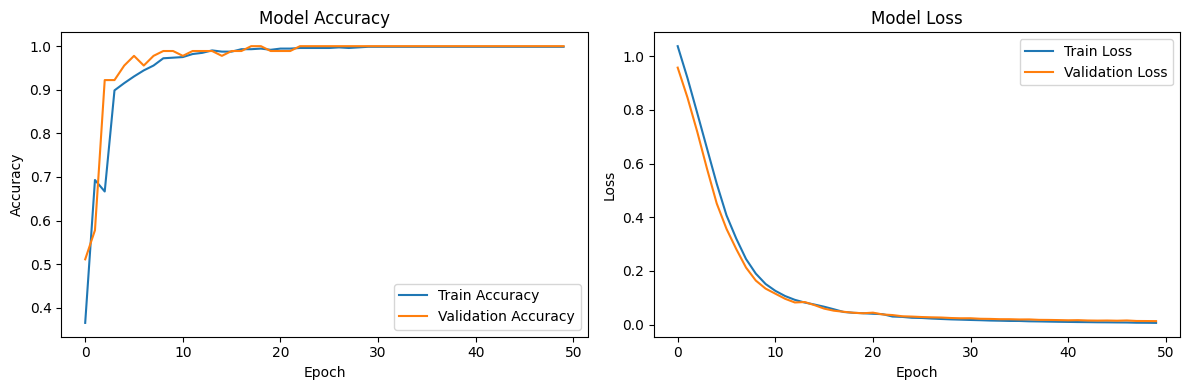

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [38]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step - accuracy: 1.0000 - loss: 0.0115
Test Accuracy: 100.0
